In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from prophet import Prophet
import xgboost as xgb
import warnings
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import lightgbm as lgb
warnings.filterwarnings("ignore")

### DATA CLEANING PART

In [10]:
# ====== Data Cleaning Script ======

# === find the path of project root ===
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "data"
CLEAN_DIR = BASE_DIR / "clean_data"

CLEAN_DIR.mkdir(exist_ok=True)

# === read train / test ===
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")

# === train: transform date ===
train['date'] = pd.to_datetime(train['date'], errors='coerce')
train.to_csv(CLEAN_DIR / "train_clean.csv", index=False)

# === train: create date features ===
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.weekday
train.to_csv(CLEAN_DIR / "train_clean.csv", index=False)

# === train: combine holidays ===
holidays = pd.read_csv(DATA_DIR / "holidays_events.csv")
holidays['date'] = pd.to_datetime(holidays['date'], errors='coerce')
train = train.merge(holidays[['date', 'type', 'description']], on='date', how='left')
train['is_holiday'] = train['type'].notnull().astype(int)
train['holiday_type'] = train['type'].fillna('None')
train['holiday_name'] = train['description'].fillna('')
train.to_csv(CLEAN_DIR / "train_clean.csv", index=False)

# === handle sales column: negative values and outliers (99% quantile truncation) ===
train = pd.read_csv(CLEAN_DIR / "train_clean.csv", low_memory=False)
if "sales" in train.columns:
    train["sales"] = pd.to_numeric(train["sales"], errors="coerce")
    median_sales = train["sales"].median()
    train["sales"] = train["sales"].fillna(median_sales)
    upper_limit = train["sales"].quantile(0.99)
    train["sales"] = train["sales"].clip(lower=0, upper=upper_limit)
train.to_csv(CLEAN_DIR / "train_clean.csv", index=False)

# === normalize continuous variables (sales, transactions) ===
scaler = MinMaxScaler()
train = pd.read_csv(CLEAN_DIR / "train_clean.csv", low_memory=False)

if "sales" in train.columns:
    train["sales_norm"] = scaler.fit_transform(train[["sales"]])

try:
    transactions = pd.read_csv(CLEAN_DIR / "transactions_clean.csv", low_memory=False)
    if "transactions" in transactions.columns:
        transactions["transactions_norm"] = scaler.fit_transform(transactions[["transactions"]])
        transactions.to_csv(CLEAN_DIR / "transactions_clean.csv", index=False)
except FileNotFoundError:
    pass

train.to_csv(CLEAN_DIR / "train_clean.csv", index=False)

# === test: transform date ===
test['date'] = pd.to_datetime(test['date'], errors='coerce')
test.to_csv(CLEAN_DIR / "test_clean.csv", index=False)

# === test: create date features ===
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['weekday'] = test['date'].dt.weekday
test.to_csv(CLEAN_DIR / "test_clean.csv", index=False)

# === test: combine holidays ===
test = test.merge(holidays[['date', 'type', 'description']], on='date', how='left')
test['is_holiday'] = test['type'].notnull().astype(int)
test['holiday_type'] = test['type'].fillna('None')
test['holiday_name'] = test['description'].fillna('')
test.to_csv(CLEAN_DIR / "test_clean.csv", index=False)

# === load original data and transform to category ===
train_df  = pd.read_csv(DATA_DIR / "train.csv")
stores_df = pd.read_csv(DATA_DIR / "stores.csv")
cat_cols_train = ['family']
cat_cols_stores = ['type', 'city', 'state', 'cluster']
for col in cat_cols_train:
    if col in train_df.columns:
        train_df[col] = train_df[col].astype('category')
for col in cat_cols_stores:
    if col in stores_df.columns:
        stores_df[col] = stores_df[col].astype('category')

# === generate cross features ===
train_merged = train_df.merge(stores_df[['store_nbr', 'type']], on='store_nbr', how='left')
train_merged['store_type_item_family'] = (
    train_merged['type'].astype(str) + "_" + train_merged['family'].astype(str)
)

# === on promotion date in a roll ===
def mark_promo_streak(group: pd.DataFrame) -> pd.Series:
    streak = pd.Series(0, index=group.index)
    current = 0
    for i in range(len(group)):
        if group.loc[group.index[i], "onpromotion"]:
            current += 1
        else:
            current = 0
        streak.iloc[i] = current
    return streak

train_df = train_df.sort_values(["store_nbr", "family", "date"])
train_df["promo_streak"] = (
    train_df.groupby(["store_nbr", "family"], group_keys=False)
            .apply(mark_promo_streak)
)

# === clean oil and transactions ===
file_oil = pd.read_csv(DATA_DIR / "oil.csv")
file_transactions = pd.read_csv(DATA_DIR / "transactions.csv")
file_oil.fillna({"dcoilwtico": file_oil["dcoilwtico"].mean()}, inplace=True)
file_transactions.fillna({
    "store_nbr": file_transactions["store_nbr"].mean(),
    "transactions": file_transactions["transactions"].mean()
}, inplace=True)
file_oil.to_csv(CLEAN_DIR / "oil_clean.csv", index=False)
file_transactions.to_csv(CLEAN_DIR / "transactions_clean.csv", index=False)

# === merge transactions ===
transaction = pd.read_csv(CLEAN_DIR / "transactions_clean.csv")
result = transaction.groupby(["store_nbr", "date"])["transactions"].sum().reset_index()
result.to_csv(CLEAN_DIR / "result.csv", index=False)

# === create is_promo feature ===
file_test = pd.read_csv(CLEAN_DIR / "test_clean.csv")
file_train = pd.read_csv(CLEAN_DIR / "train_clean.csv")
file_test['is_promo'] = (file_test['onpromotion'] > 0).astype(int)
file_train['is_promo'] = (file_train['onpromotion'] > 0).astype(int)
file_test.to_csv(CLEAN_DIR / "test_clean.csv", index=False)
file_train.to_csv(CLEAN_DIR / "train_clean.csv", index=False)

# === combine stores information ===
train = pd.read_csv(CLEAN_DIR / "train_clean.csv")
stores = pd.read_csv(DATA_DIR / "stores.csv")
train_merged = train.merge(stores, on="store_nbr", how="left")
train_merged.to_csv(CLEAN_DIR / "train_with_store_info.csv", index=False)

# === combine oil information ===
train = pd.read_csv(CLEAN_DIR / "train_with_store_info.csv")
oil = pd.read_csv(DATA_DIR / "oil.csv")
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
train = train.merge(oil[['date','dcoilwtico']], on='date', how='left')
train.to_csv(CLEAN_DIR / "train_with_store_oil.csv", index=False)

# === create city_family feature ===
file_train = pd.read_csv(CLEAN_DIR / "train_clean.csv")
file_stores = pd.read_csv(DATA_DIR / "stores.csv")
file_test = pd.read_csv(CLEAN_DIR / "test_clean.csv")
merged_train = file_train.merge(file_stores, on='store_nbr', how='left')
file_train['city_family'] = merged_train['city'] + '_' + merged_train['family']
file_train.to_csv(CLEAN_DIR / "train_clean.csv", index=False)

### VISULISATION PART

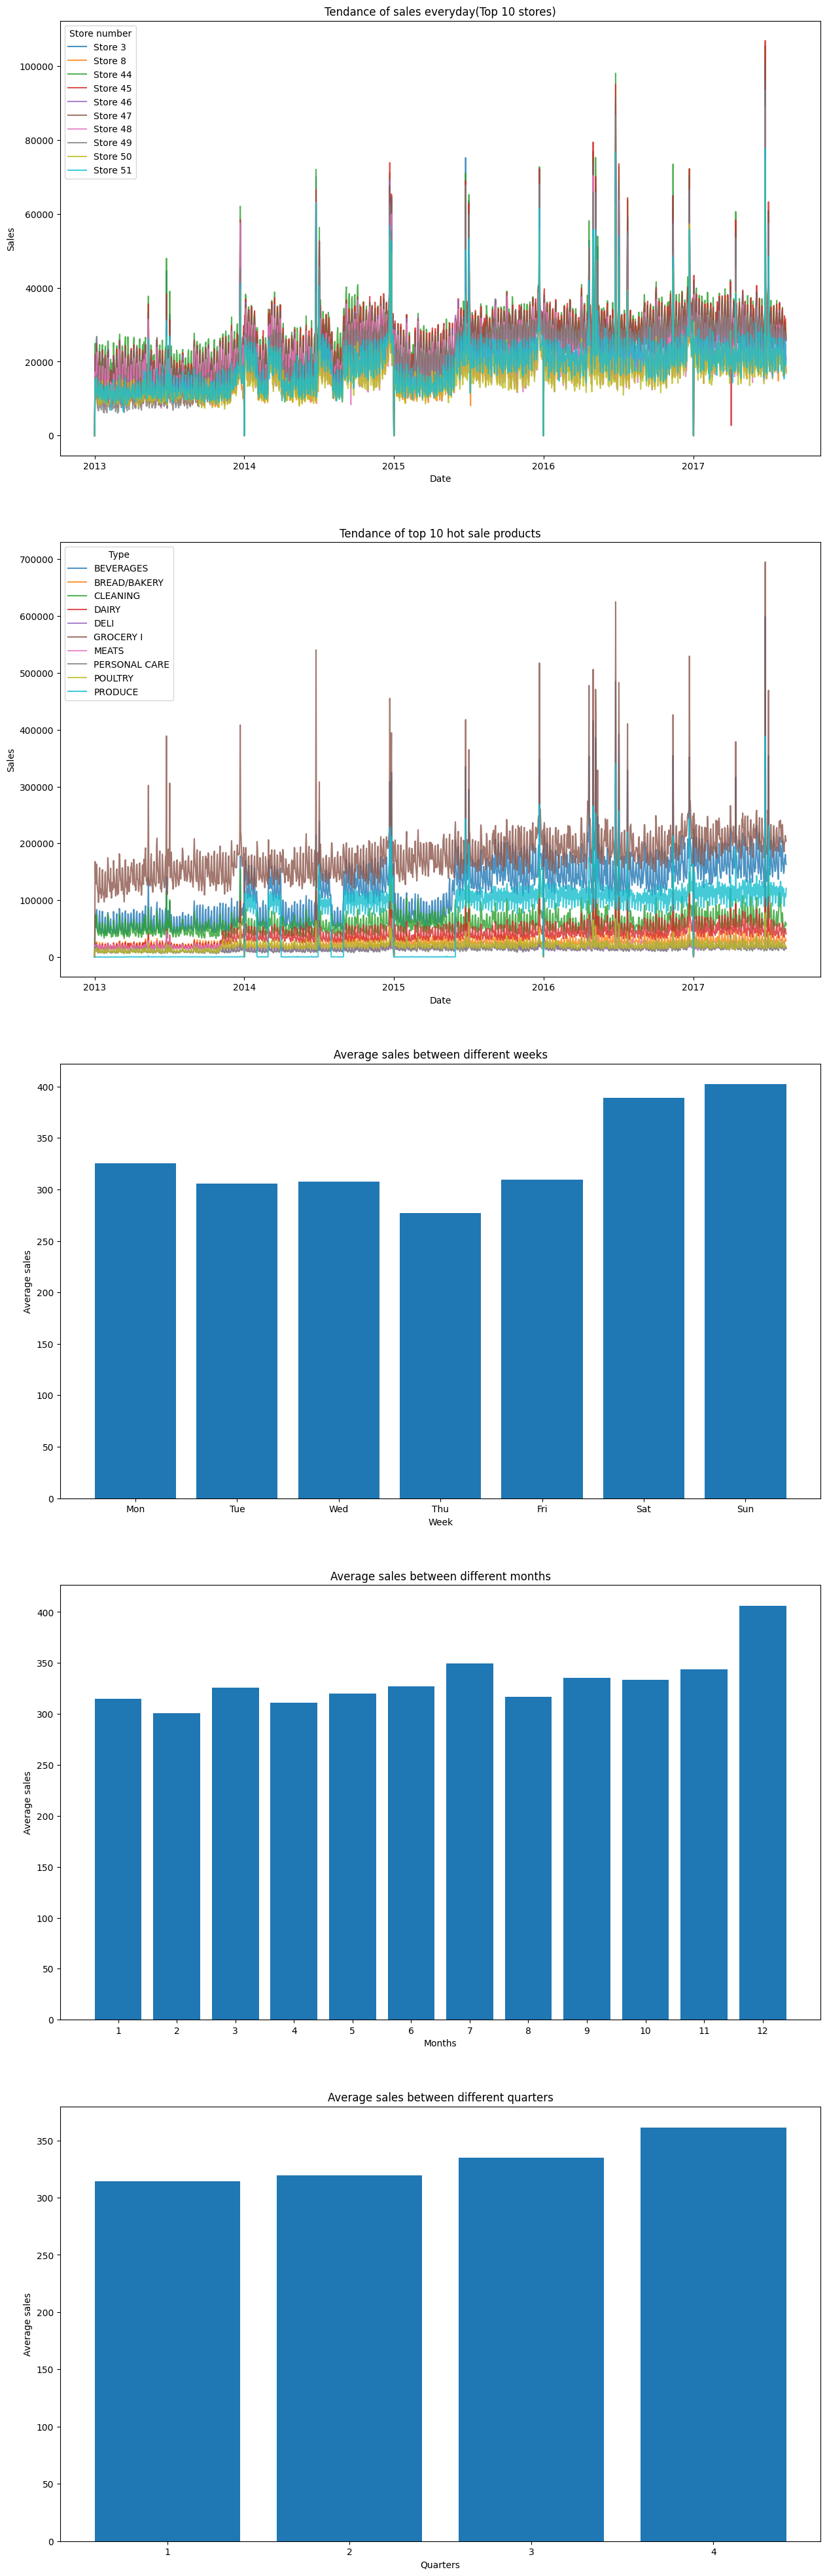

In [3]:
data = pd.read_csv("../clean_data/train_clean.csv")
data["date"] = pd.to_datetime(data["date"])

daily_store = data.groupby(["date", "store_nbr"])["sales"].sum().reset_index()

top_stores = data.groupby("store_nbr")["sales"].sum().nlargest(10).index

daily_store_top = daily_store[daily_store["store_nbr"].isin(top_stores)]

top_families = data.groupby("family")["sales"].sum().nlargest(10).index

df_top_family = data[data["family"].isin(top_families)]

daily_family = df_top_family.groupby(["date", "family"])["sales"].sum().reset_index()

data["weekday_num"] = data["date"].dt.weekday
data["weekday_name"] = data["date"].dt.day_name()

weekday_order = [0, 1, 2, 3, 4, 5, 6]

weekday_sales = data.groupby("weekday_num")["sales"].mean().reindex(weekday_order).reset_index()

weekday_map = {0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"}
weekday_sales["weekday"] = weekday_sales["weekday_num"].map(weekday_map)

data["month"] = data["date"].dt.month

month_sales = data.groupby("month")["sales"].mean().reset_index()

data["quarter"] = data["date"].dt.quarter

quarter_sales = data.groupby("quarter")["sales"].mean().reset_index()



fig, axs = plt.subplots(5,1,figsize=(15,50))

# plot1

for store, sub in daily_store_top.groupby("store_nbr"):
    axs[0].plot(sub["date"], sub["sales"], label=f"Store {store}", alpha=0.8)
axs[0].set_title("Tendance of sales everyday(Top 10 stores)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Sales")
axs[0].legend(title="Store number")


# plot2

for fam, sub in daily_family.groupby("family"):
    axs[1].plot(sub["date"], sub["sales"], label=fam, alpha=0.8)

axs[1].set_title("Tendance of top 10 hot sale products")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Sales")
axs[1].legend(title="Type")


# plot3

axs[2].bar(weekday_sales["weekday"], weekday_sales["sales"])
axs[2].set_title("Average sales between different weeks")
axs[2].set_xlabel("Week")
axs[2].set_ylabel("Average sales")


# plot4

axs[3].bar(month_sales["month"], month_sales["sales"])
axs[3].set_xticks(range(1, 13))
axs[3].set_title("Average sales between different months")
axs[3].set_xlabel("Months")
axs[3].set_ylabel("Average sales")


# plot5


axs[4].bar(quarter_sales["quarter"], quarter_sales["sales"])
axs[4].set_xticks([1, 2, 3, 4])
axs[4].set_title("Average sales between different quarters")
axs[4].set_xlabel("Quarters")
axs[4].set_ylabel("Average sales")

plt.savefig("../figures/figures for tendance and average sales.jpg",dpi=300,bbox_inches='tight')
plt.show()


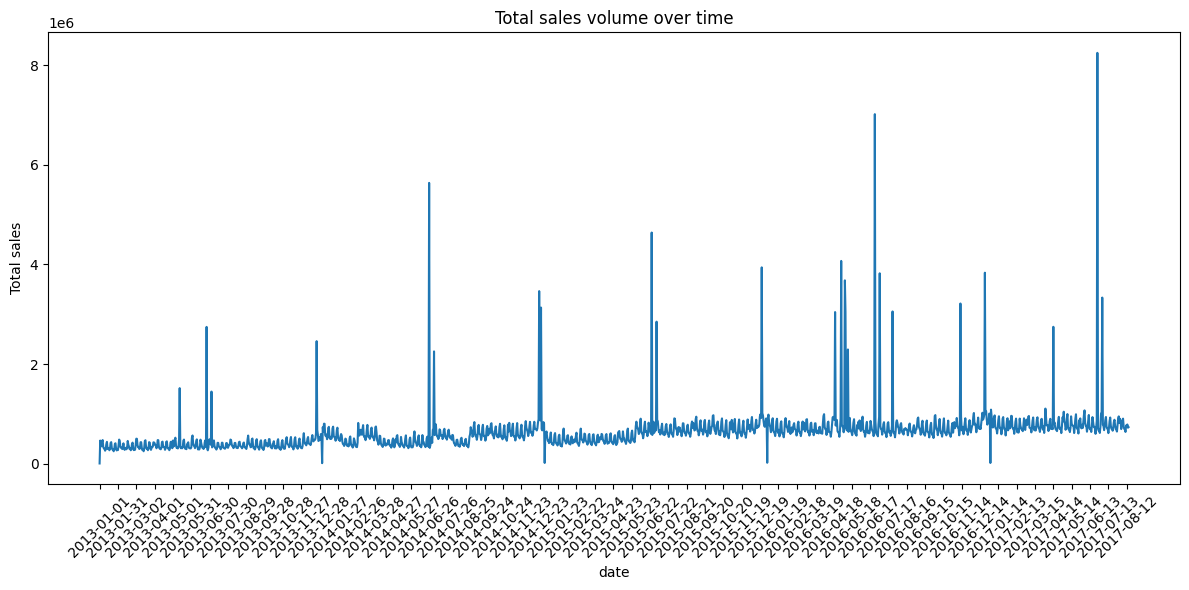

In [4]:
train = pd.read_csv('../clean_data/train_final.csv')
daily_sales = train.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.xticks(daily_sales['date'][::30], rotation=45)
plt.xlabel('date')
plt.ylabel('Total sales')
plt.title('Total sales volume over time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../figures/Total sales volume over time.jpg", format='jpg', dpi=300)
plt.show()

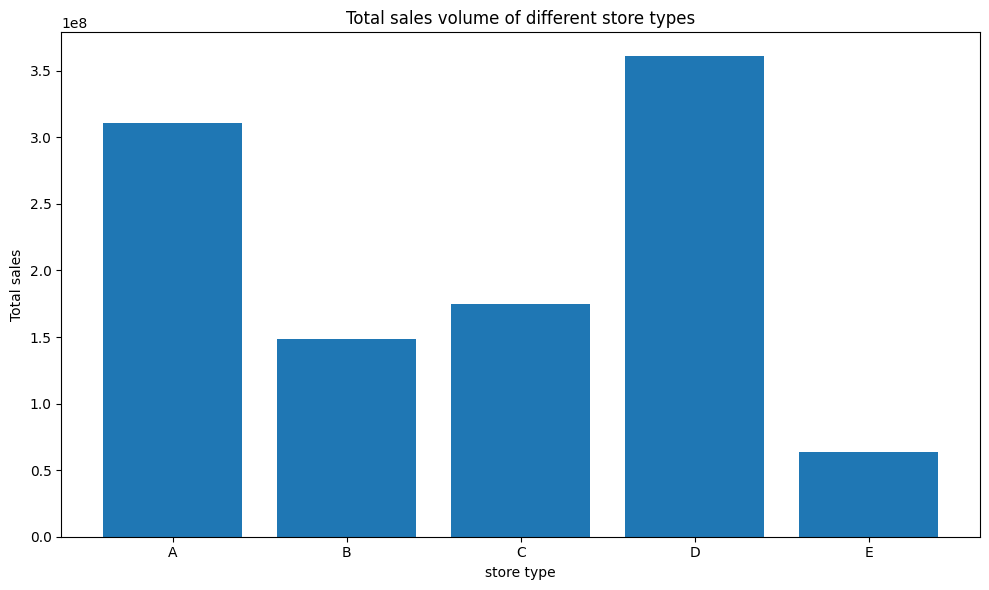

In [5]:
store_sales = train.groupby('type_y')['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.bar(store_sales['type_y'], store_sales['sales'])

plt.xlabel('store type')
plt.ylabel('Total sales')
plt.title('Total sales volume of different store types')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../figures/Total sales volume of different store types.jpg", format='jpg', dpi=300)
plt.show()

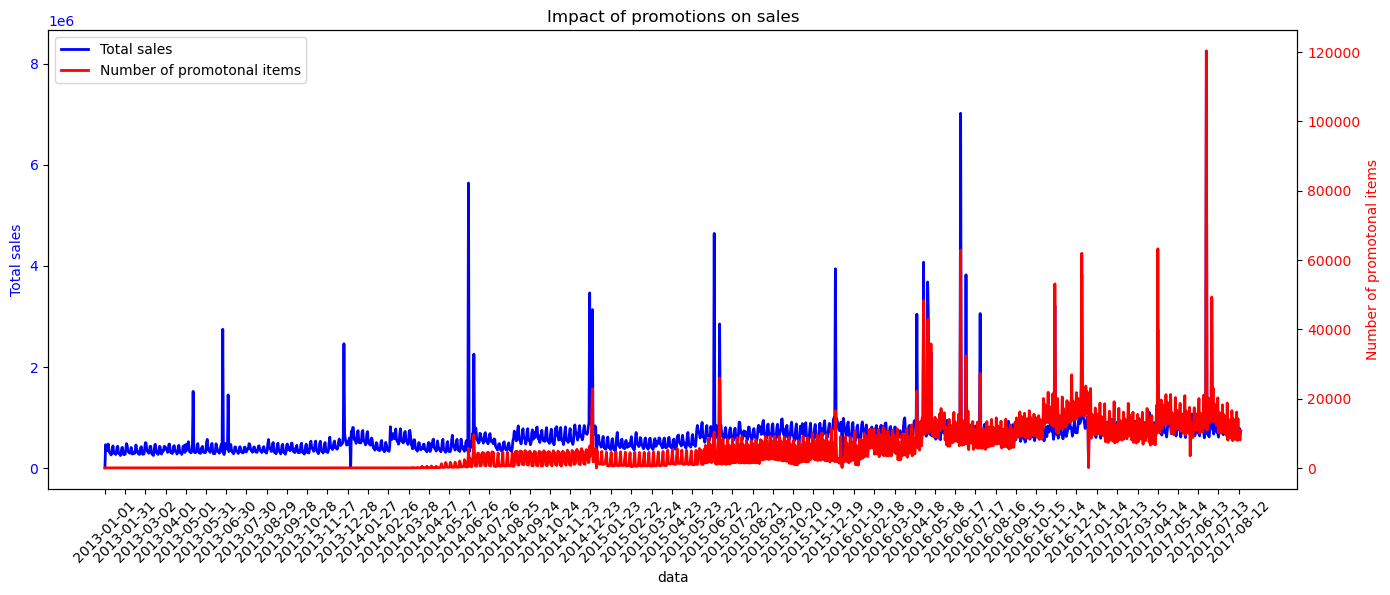

In [ ]:
train['date'] = pd.to_datetime(train['date'])
daily_summary = train.groupby('date').agg({'sales':'sum', 'onpromotion':'sum'}).reset_index()
fig, ax1 = plt.subplots(figsize=(14,6))
ax2 = ax1.twinx()
ax1.plot(daily_summary['date'], daily_summary['sales'], color='blue', label='Total sales', linewidth=2)
ax1.set_ylabel('Total sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.plot(daily_summary['date'], daily_summary['onpromotion'], color='red', label='Number of promotonal items', linewidth=2)
ax2.set_ylabel('Number of promotonal items', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax1.set_xlabel('data')
ax1.set_xticks(daily_summary['date'][::30])
ax1.set_xticklabels(daily_summary['date'][::30].dt.strftime('%Y-%m-%d'), rotation=45)
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
fig.tight_layout()
plt.title('Impact of promotions on sales')
plt.savefig("../figures/Impact of promotions on sales.jpg", format='jpg', dpi=300)
plt.show()


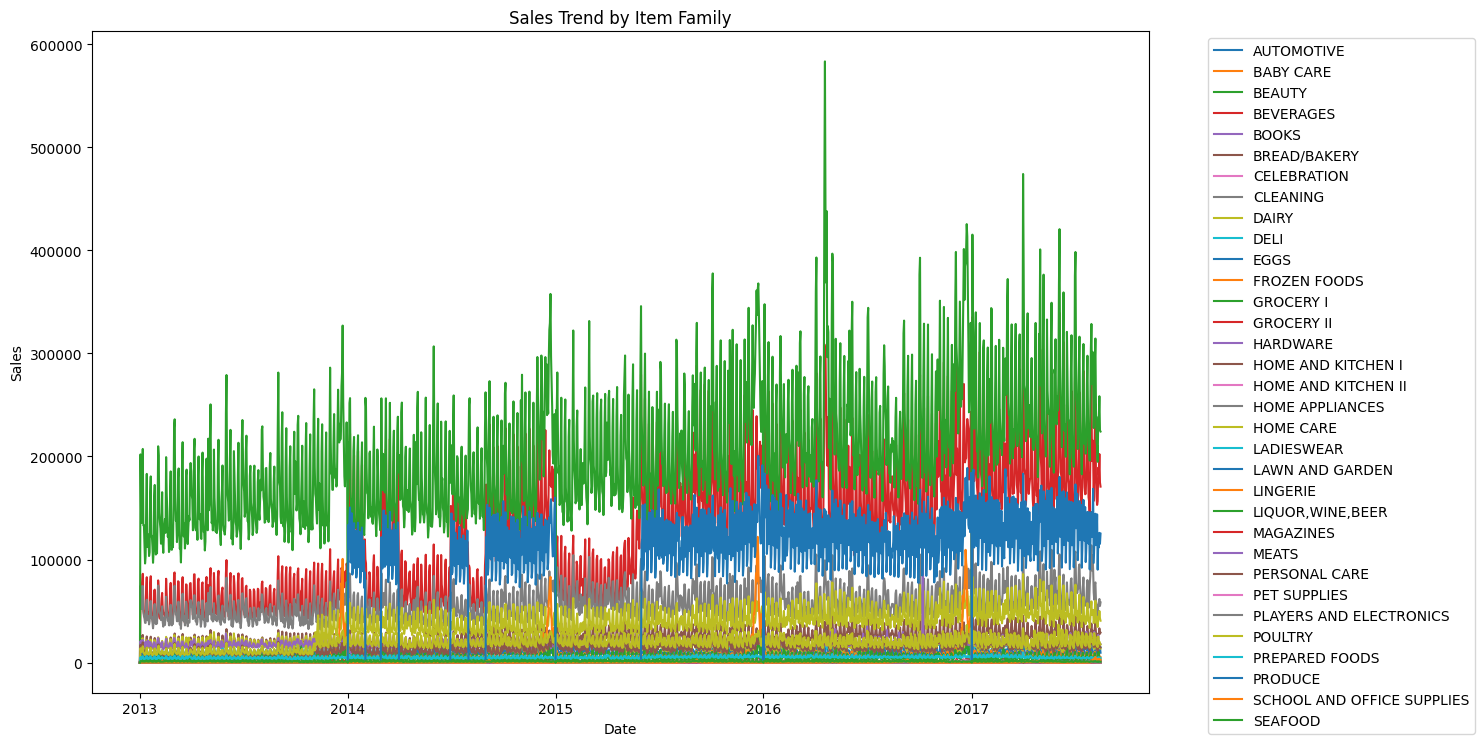

<Figure size 640x480 with 0 Axes>

In [21]:
train_df["date"] = pd.to_datetime(train_df["date"])

df_family = (
    train_df.groupby(["date", "family"])["sales"]
            .sum()
            .reset_index()
)

plt.figure(figsize=(15, 8))

for fam in df_family["family"].unique():
    sub = df_family[df_family["family"] == fam]
    plt.plot(sub["date"], sub["sales"], label=fam)

plt.title("Sales Trend by Item Family")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.savefig("../figures/item_family_sales.jpg", dpi=300, bbox_inches="tight")

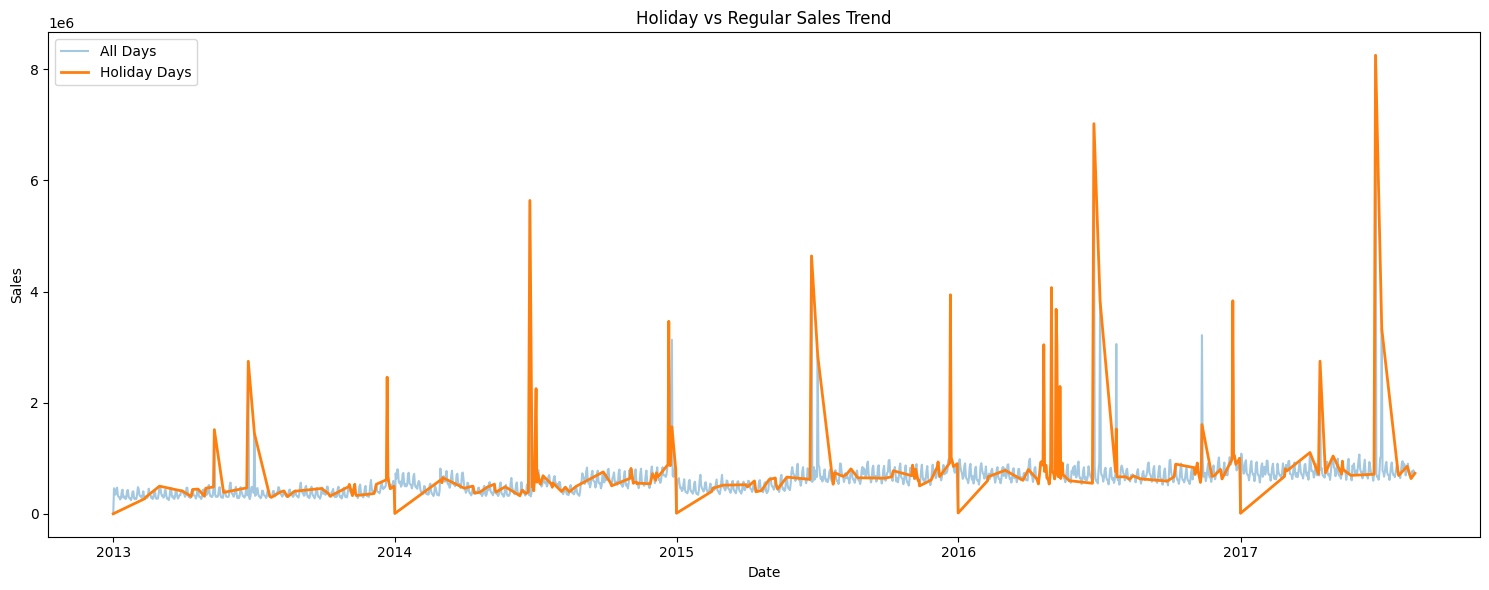

<Figure size 640x480 with 0 Axes>

In [22]:
holidays_df = pd.read_csv('../data/holidays_events.csv')
holidays_df["date"] = pd.to_datetime(holidays_df["date"])
train["date"] = pd.to_datetime(train["date"])

df = train.merge(
    holidays_df[["date", "type", "locale", "description"]],
    on="date",
    how="left"
)

holiday_types = ["Holiday", "Event", "Additional"]
df_holiday = df[df["type"].isin(holiday_types)]

daily_sales = df.groupby("date")["sales"].sum().reset_index()

holiday_sales = (
    df_holiday.groupby("date")["sales"].sum().reset_index()
)

plt.figure(figsize=(15, 6))

plt.plot(daily_sales["date"], daily_sales["sales"],
         label="All Days", alpha=0.4)

plt.plot(holiday_sales["date"], holiday_sales["sales"],
         label="Holiday Days", linewidth=2)

plt.title("Holiday vs Regular Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

plt.savefig("../figures/holiday_vs_regular_sales.jpg", dpi=300, bbox_inches="tight")


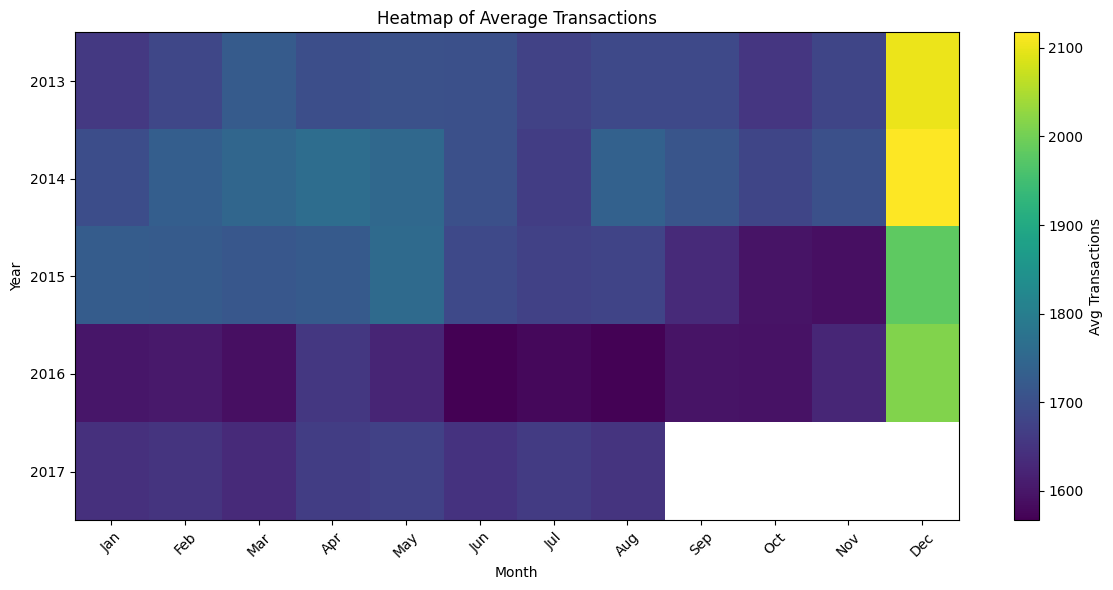

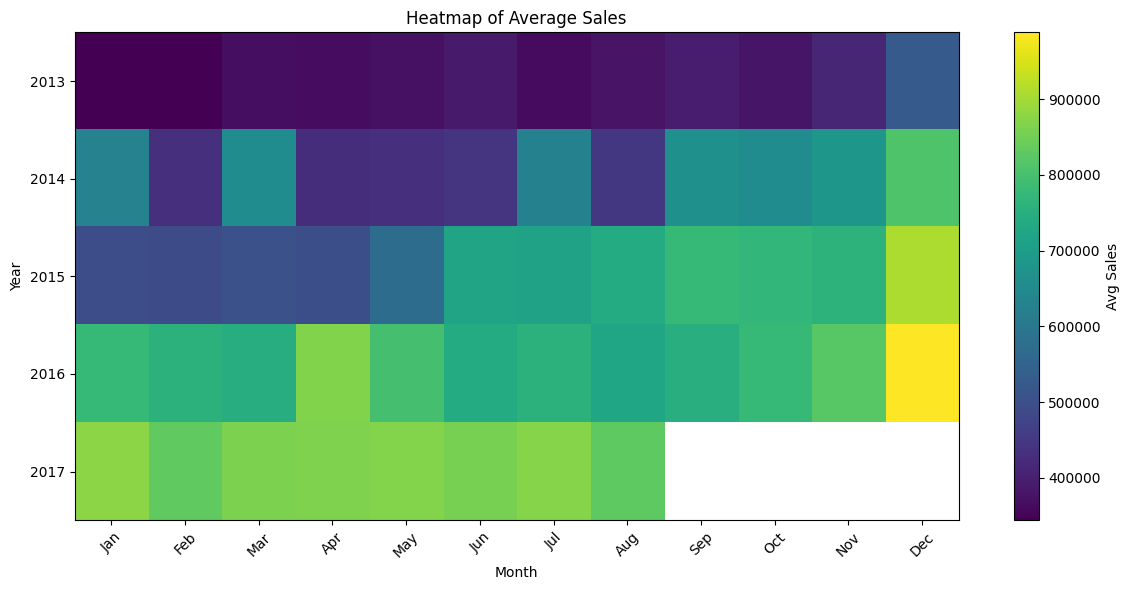

In [23]:
transactions_df = pd.read_csv(DATA_DIR / "transactions.csv")
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
train_df["date"] = pd.to_datetime(train_df["date"])

sales_daily = (
    train_df.groupby("date")["sales"]
            .sum()
            .reset_index()
)

df_ts = sales_daily.merge(transactions_df, on="date", how="left")

df_ts["year"] = df_ts["date"].dt.year
df_ts["month"] = df_ts["date"].dt.month

pivot_trans = df_ts.pivot_table(
    index="year", columns="month",
    values="transactions", aggfunc="mean"
)

pivot_sales = df_ts.pivot_table(
    index="year", columns="month",
    values="sales", aggfunc="mean"
)

def plot_heatmap(pivot_df, title, label, filename):
    plt.figure(figsize=(12, 6))
    data = pivot_df.values
    im = plt.imshow(data, cmap="viridis", aspect="auto")
    cbar = plt.colorbar(im)
    cbar.set_label(label)

    plt.xticks(
        np.arange(12),
        ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
        rotation=45
    )
    plt.yticks(np.arange(len(pivot_df.index)), pivot_df.index)

    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Year")
    plt.tight_layout()
    plt.savefig(f"../figures/{filename}", dpi=300, bbox_inches="tight")
    plt.show()

plot_heatmap(
    pivot_trans,
    "Heatmap of Average Transactions",
    "Avg Transactions",
    "transactions_heatmap.jpg"
)

plot_heatmap(
    pivot_sales,
    "Heatmap of Average Sales",
    "Avg Sales",
    "sales_heatmap.jpg"
)

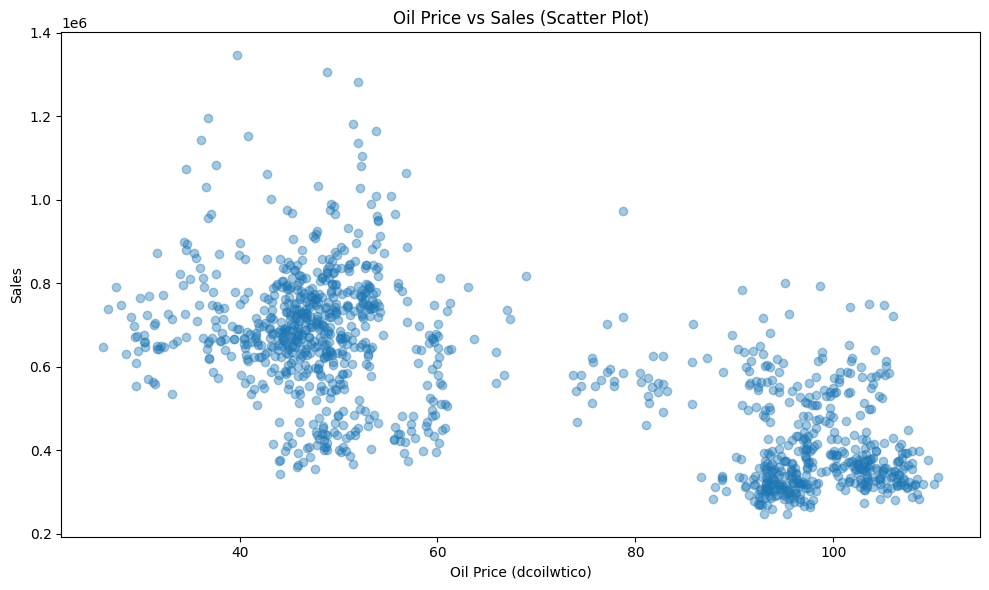

<Figure size 640x480 with 0 Axes>

In [24]:
oil_df = pd.read_csv(DATA_DIR / "oil.csv")
oil_df["date"] = pd.to_datetime(oil_df["date"])

train_df["date"] = pd.to_datetime(train_df["date"])

sales_daily = (
    train_df.groupby("date")["sales"]
            .sum()
            .reset_index()
)

df_oil = sales_daily.merge(oil_df, on="date", how="left")

plt.figure(figsize=(10, 6))

plt.scatter(df_oil["dcoilwtico"], df_oil["sales"], alpha=0.4)

plt.title("Oil Price vs Sales (Scatter Plot)")
plt.xlabel("Oil Price (dcoilwtico)")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()
plt.savefig("../figures/oil_vs_sales_scatter.jpg", dpi=300, bbox_inches="tight")

### PREDICTION PART

Create the baseline (Moving Average 7 Days prediction)

In [ ]:
base_data = pd.read_csv("../clean_data/train_clean.csv")

base_data["date"] = pd.to_datetime(base_data["date"])

base_data = base_data.sort_values(["store_nbr", "family", "date"])

base_data_groupby = base_data.groupby(["store_nbr", "family"])

base_data["pred_ma7"] = base_data_groupby["sales"].transform(lambda s: s.shift(1).rolling(7).mean())
base_data["pred_ma7"]  = base_data["pred_ma7"].fillna(base_data["sales"].mean())

Linear Regression with the time step feature 1 Day

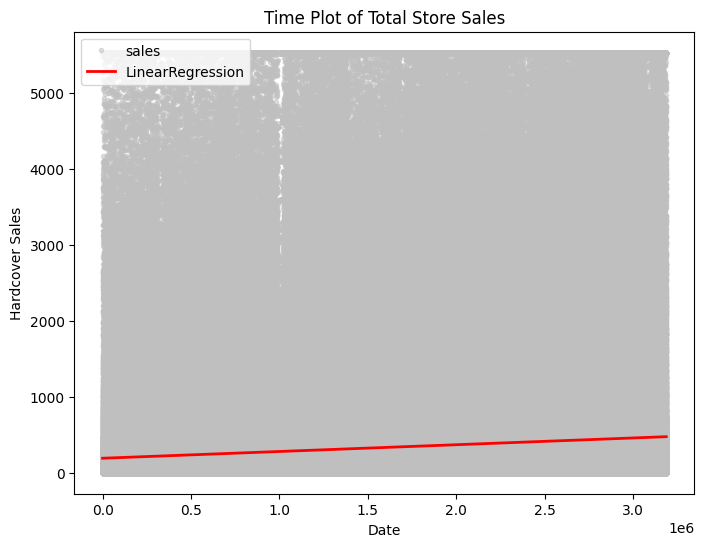

In [6]:
trying = pd.read_csv("../clean_data/train_final.csv")

time = np.arange(len(trying.index))

trying["time"] = time


X = trying.loc[:, ["time"]]
y = trying.loc[:, "sales"]

model = LinearRegression()
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots(figsize=(8,6))
ax = y.plot(color='0.75', style='.', xlabel='Date', ylabel='Hardcover Sales', alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=2, label='LinearRegression', color='red')
ax.set_title('Time Plot of Total Store Sales')
ax.legend(loc="upper left")
plt.savefig("../figures/Time Plot of Total Store Sales.jpg", dpi=300, bbox_inches="tight")
plt.show()


Training and Predicting with the model Prophet

15:28:00 - cmdstanpy - INFO - Chain [1] start processing
15:28:00 - cmdstanpy - INFO - Chain [1] done processing


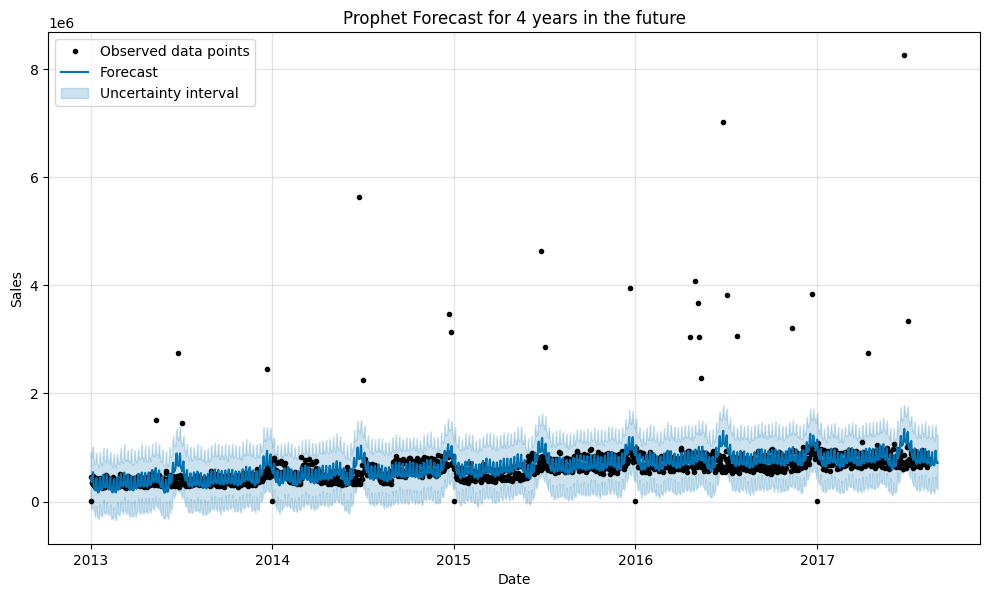

In [7]:
# read the data
training = pd.read_csv("../clean_data/train_final.csv")
testing = pd.read_csv("../clean_data/test_clean.csv")


# take out the columns we need
data_proph = training.groupby("date", as_index=False)["sales"].sum().rename(columns={"date": "ds", "sales": "y"})

# take the model initialise it
model_proph = Prophet()
model_proph.fit(data_proph)

# predict the future
prediction = model_proph.predict(model_proph.make_future_dataframe(periods=16))

# draw the plot
model_proph.plot(prediction)
plt.legend(loc="upper left")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Prophet Forecast for 4 years in the future")
plt.savefig("../figures/Prophet Forecast for 4 years in the future.jpg", dpi=300, bbox_inches="tight")
plt.show()


Training and Predicting with the model Xgboost

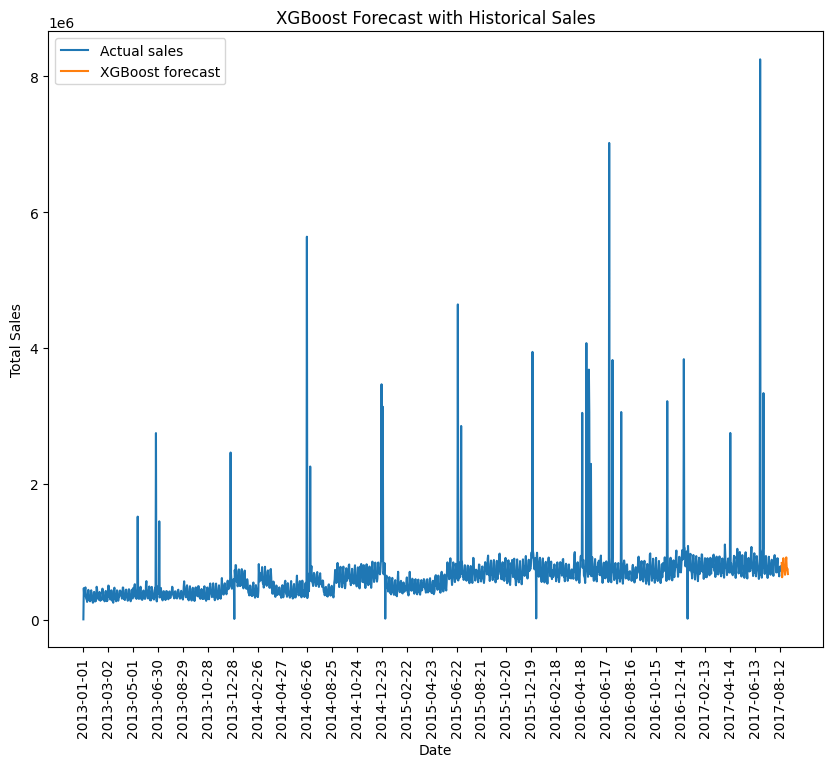

In [8]:
# take out the columns we need
data_xgb = training[["store_nbr", "family", "onpromotion", "year", "month", "weekday", "is_holiday", "is_promo"]]
data_xgb_test = testing[["store_nbr", "family", "onpromotion", "year", "month", "weekday", "is_holiday", "is_promo"]]

# train the model
y_xgb = training["sales"]
model_xgb = xgb.XGBRegressor()
X = pd.get_dummies(data_xgb, drop_first=True)
model_xgb.fit(X, y_xgb)

# predict
X_test = pd.get_dummies(data_xgb_test, drop_first=True)
y_pred = model_xgb.predict(X_test)

# draw the plot
pred_df = testing[["date"]].copy()
pred_df["pred"] = y_pred
pred_daily = pred_df.groupby("date", as_index=False)["pred"].sum()
daily_train = training.groupby("date", as_index=False)["sales"].sum()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(daily_train["date"], daily_train["sales"],label="Actual sales")
ax.plot(pred_daily["date"], pred_daily["pred"],label="XGBoost forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Total Sales")
ax.set_title("XGBoost Forecast with Historical Sales")
all_dates = pd.concat([daily_train["date"], pred_daily["date"]])
ax.set_xticks(all_dates[::60])
ax.tick_params(axis='x', rotation=90)

ax.legend()
plt.savefig("../figures/XGBoost Forecast with Historical Sales.jpg", dpi=300, bbox_inches="tight")
plt.show()


Training and Predicting with the model SARIMA

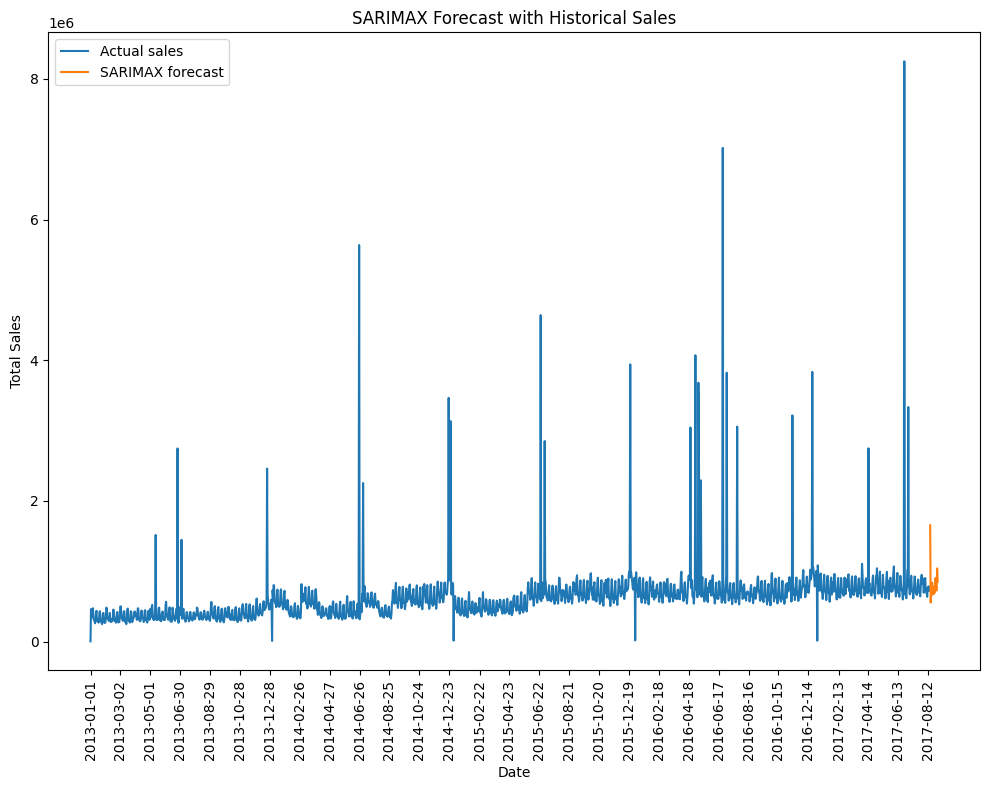

In [11]:
training = pd.read_csv(CLEAN_DIR / "train_final.csv")
testing  = pd.read_csv(CLEAN_DIR / "test_clean.csv")

training["date"] = pd.to_datetime(training["date"])
testing["date"]  = pd.to_datetime(testing["date"])

train_daily = training.groupby("date", as_index=False)["sales"].sum().sort_values("date")
train_daily = train_daily.set_index("date")

exog_cols_candidates = ["onpromotion", "is_holiday", "is_promo"]
available_exog = [c for c in exog_cols_candidates if c in training.columns]

if available_exog:
    agg_map = {}
    for c in available_exog:
        if c == "onpromotion":
            agg_map[c] = "sum"
        else:
            agg_map[c] = "max"

    train_exog = (training.groupby("date", as_index=False)[available_exog]
                        .agg(agg_map)
                        .sort_values("date")
                        .set_index("date"))

    test_exog = (testing.groupby("date", as_index=False)[available_exog]
                      .agg(agg_map)
                      .sort_values("date")
                      .set_index("date"))
else:
    train_exog, test_exog = None, None


h = testing["date"].nunique()
future_dates = pd.Index(sorted(testing["date"].unique()), name="date")


order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

model = SARIMAX(
    train_daily["sales"],
    exog=train_exog,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = model.fit(disp=False)

forecast = res.get_forecast(steps=h, exog=test_exog)
pred_mean = forecast.predicted_mean
pred_mean.index = future_dates  

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(train_daily.index, train_daily["sales"], label="Actual sales")
ax.plot(pred_mean.index, pred_mean.values, label="SARIMAX forecast")

ax.set_xlabel("Date")
ax.set_ylabel("Total Sales")
ax.set_title("SARIMAX Forecast with Historical Sales")

all_dates = pd.Index(train_daily.index.tolist() + pred_mean.index.tolist())
ax.set_xticks(all_dates[::60])
ax.tick_params(axis="x", rotation=90)

ax.legend()
plt.tight_layout()
plt.savefig("../figures/SARIMAX Forecast with Historical Sales.jpg", dpi=300, bbox_inches="tight")
plt.show()

Training and Predicting with the model LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 3186216, number of used features: 39
[LightGBM] [Info] Start training from score 332.290577


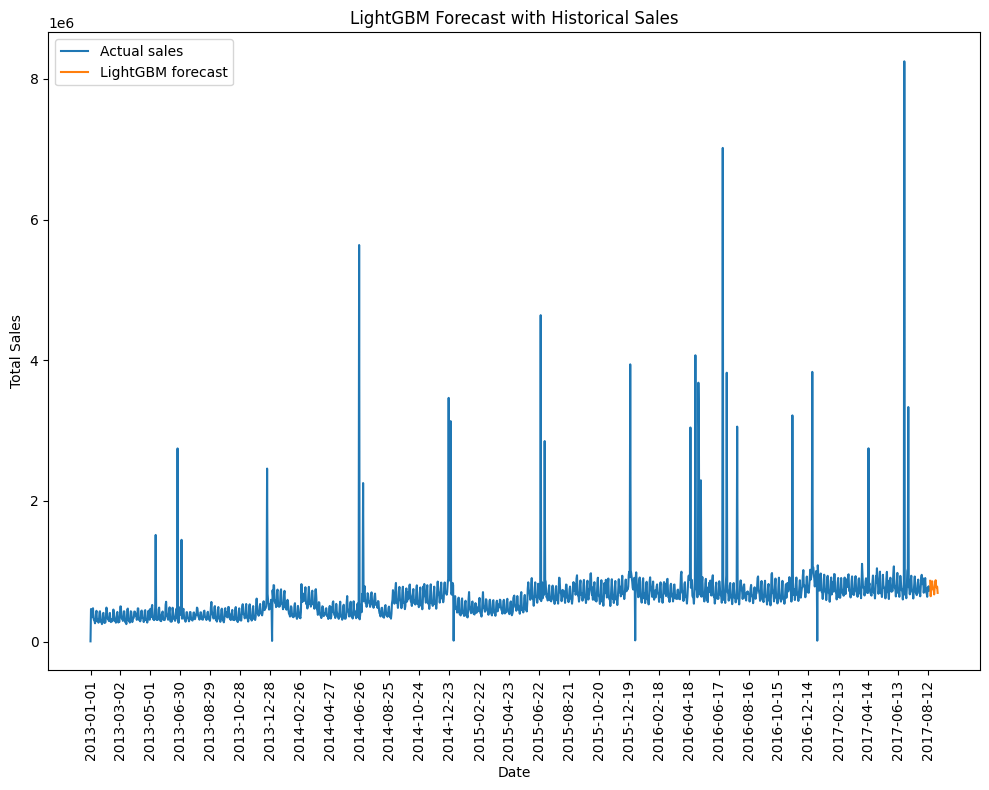

In [12]:
training = pd.read_csv(CLEAN_DIR / "train_final.csv")
testing  = pd.read_csv(CLEAN_DIR / "test_clean.csv")

training["date"] = pd.to_datetime(training["date"])
testing["date"]  = pd.to_datetime(testing["date"])

feature_cols = ["store_nbr", "family", "onpromotion", "year", "month", "weekday", "is_holiday", "is_promo"]

X_train_raw = training[feature_cols]
y_train = training["sales"]

X_test_raw = testing[feature_cols]


X_train = pd.get_dummies(X_train_raw, drop_first=True)
X_test  = pd.get_dummies(X_test_raw, drop_first=True)


X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


def sanitize_columns(cols):
    cols = cols.astype(str)
    cols = cols.str.replace(r"[^A-Za-z0-9_]+", "_", regex=True)  
    return cols

X_train.columns = sanitize_columns(X_train.columns)
X_test.columns  = X_train.columns  

model_lgb = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)


model_lgb.fit(X_train, y_train)


y_pred = model_lgb.predict(X_test)

pred_df = testing[["date"]].copy()
pred_df["pred"] = y_pred
pred_daily = pred_df.groupby("date", as_index=False)["pred"].sum().sort_values("date")

daily_train = training.groupby("date", as_index=False)["sales"].sum().sort_values("date")

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(daily_train["date"], daily_train["sales"], label="Actual sales")
ax.plot(pred_daily["date"], pred_daily["pred"], label="LightGBM forecast")

ax.set_xlabel("Date")
ax.set_ylabel("Total Sales")
ax.set_title("LightGBM Forecast with Historical Sales")

all_dates = pd.concat([daily_train["date"], pred_daily["date"]])
ax.set_xticks(all_dates[::60])
ax.tick_params(axis="x", rotation=90)

ax.legend()
plt.tight_layout()
plt.savefig("../figures/LightGBM Forecast with Historical Sales.jpg", dpi=300, bbox_inches="tight")
plt.show()